<a href="https://colab.research.google.com/github/yuliastoliaruk/Computer_Vision_NaUKMA/blob/main/intel_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.utils import make_grid
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
device

device(type='cuda')

## 1. Data Preparation (Practice 1)

### Data Augmentation

In [ ]:
transform_train_data = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test_data = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
data_path = "/content/drive/MyDrive/Intel_Image_Classification/data"

data_train = torchvision.datasets.ImageFolder(root=f"{data_path}/seg_train", transform=transform_train_data)
data_test = torchvision.datasets.ImageFolder(root=f"{data_path}/seg_test", transform=transform_test_data)

In [ ]:
data_test = torchvision.datasets.ImageFolder(root=f"{data_path}/seg_test", transform=transform_test_data)

In [ ]:
print("Classes:", data_train.classes)

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### Split into training and validation sets.

In [ ]:
def images_per_class(data, dataset=None):
    if dataset is None:
        labels = data.targets
    else:
        labels = [data.targets[i] for i in dataset.indices]

    class_counts = Counter(labels)
    class_names = data.classes

    print('Number of images in each class:')
    for class_id, count in class_counts.items():
        print(f"{class_names[class_id]}: {count} images")

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, [class_counts[i] for i in range(len(class_names))], color='purple')

    plt.xlabel('Classes')
    plt.ylabel('Number of Images')

    return plt

Number of images in each class:
buildings: 437 images
forest: 474 images
glacier: 553 images
mountain: 525 images
sea: 510 images
street: 501 images


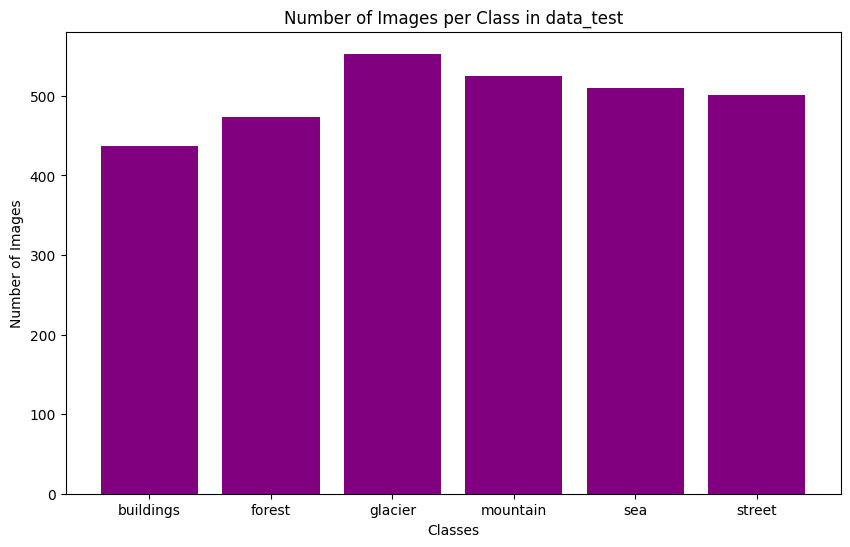

In [ ]:
plt = images_per_class(data_test)
plt.title('Number of Images per Class in data_test')
plt.show()

Number of images in each class:
buildings: 2191 images
forest: 2271 images
glacier: 2404 images
mountain: 2512 images
sea: 2274 images
street: 2382 images


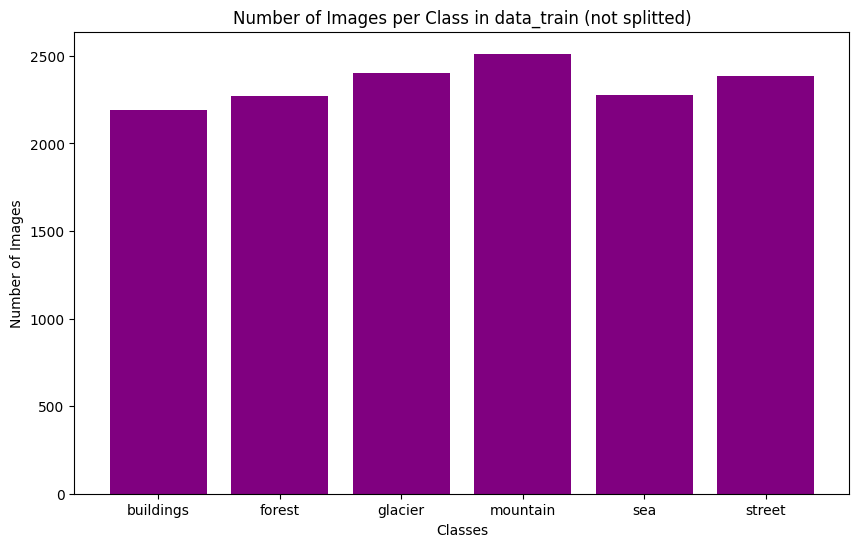

In [ ]:
plt = images_per_class(data_train)
plt.title('Number of Images per Class in data_train (not splitted)')
plt.show()

As we can see from the bar plot, the training dataset is imbalanced. To balance the data, I will take 1900 images from each class for `train_ds`, and the rest will go to `val_ds`

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

labels = np.array(data_train.targets)
num_classes = len(set(labels))
samples_per_class = 1900

class_indices = defaultdict(list)

for idx, label in enumerate(labels):
    class_indices[label].append(idx)

train_indices = []
val_indices = []

for class_id, indices in class_indices.items():
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    train_class_indices = indices[:samples_per_class]
    val_class_indices = indices[samples_per_class:]

    train_indices.extend(train_class_indices)
    val_indices.extend(val_class_indices)

train_ds = Subset(data_train, train_indices)
val_ds = Subset(data_train, val_indices)

In [ ]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(data_test, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

Number of images in each class:
buildings: 1900 images
forest: 1900 images
glacier: 1900 images
mountain: 1900 images
sea: 1900 images
street: 1900 images


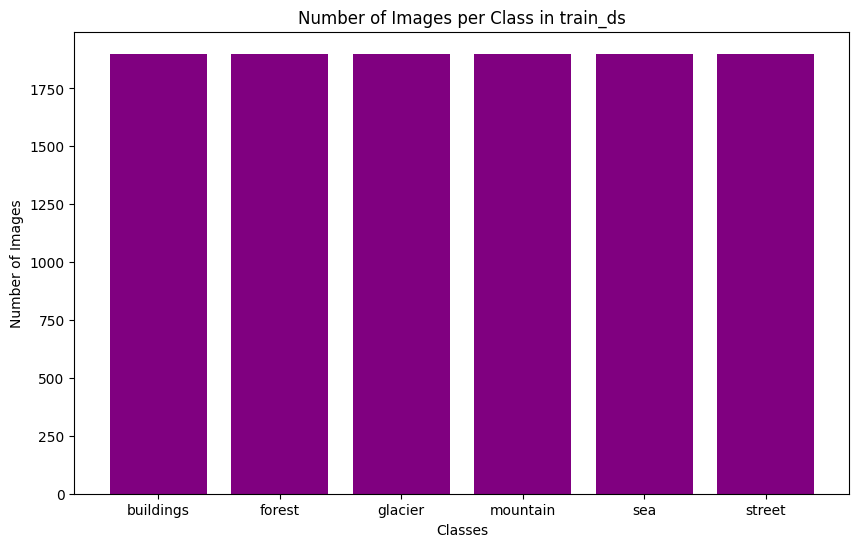

In [ ]:
plt = images_per_class(data_train, train_ds)
plt.title('Number of Images per Class in train_ds')
plt.show()

Number of images in each class:
buildings: 291 images
forest: 371 images
glacier: 504 images
mountain: 612 images
sea: 374 images
street: 482 images


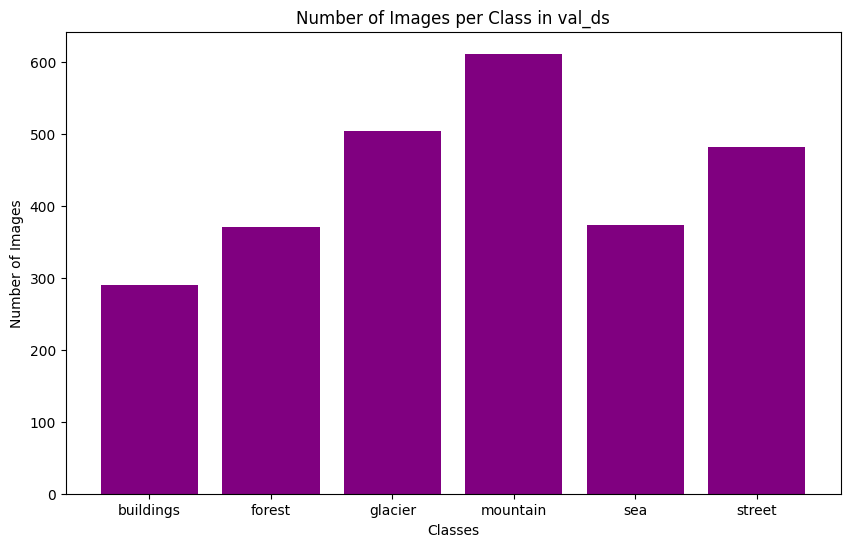

In [ ]:
plt = images_per_class(data_train, val_ds)
plt.title('Number of Images per Class in val_ds')
plt.show()

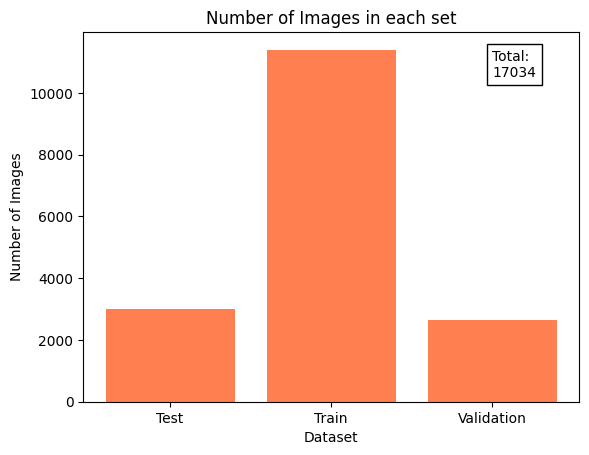

In [ ]:
plt.bar(['Test', 'Train', 'Validation'], [len(data_test), len(train_ds), len(val_ds)], color='coral')
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Number of Images in each set')
plt.text(2, len(data_train)*0.75, f"Total:\n{len(data_test) + len(data_train)}", bbox=dict(facecolor="white", edgecolor="black"))
plt.show()

### Denormalization

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy() if isinstance(img, torch.Tensor) else img
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

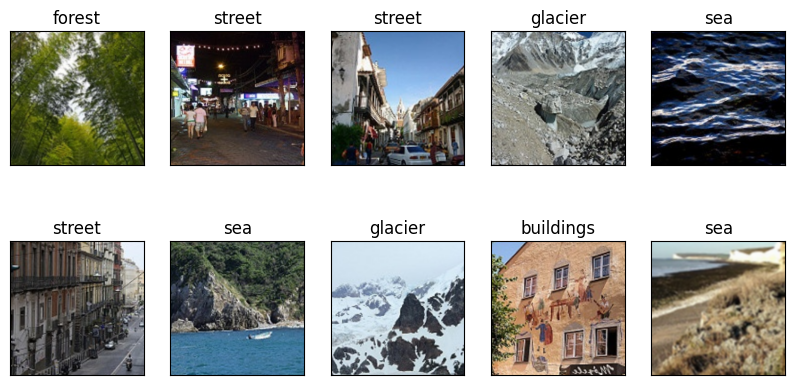

In [ ]:
classes = data_train.classes

data_iter = iter(train_dl)
images, labels = next(data_iter)
images = images.to(device)
labels = labels.to(device)

n = 10
fig = plt.figure(figsize=(n, 5))

for idx in np.arange(n):
    ax = fig.add_subplot(2, int(n/2), idx + 1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title(str(classes[labels[idx].item()]),
        color=("black")
    )

plt.show()

# 2. Basic neural network model (Practice 2)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        #self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))

        x = torch.flatten(x, start_dim=1)
        #x = self.dropout(self.relu(self.fc1(x)))
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def train(model, epochs, lr, loss_function, optimizer):
    model.to(device)
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    train_accuracies = []
    train_f1s = []
    train_precisions = []
    train_recalls = []

    val_losses = []
    val_accuracies = []
    val_f1s = []
    val_precisions = []
    val_recalls = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        for images, labels in train_dl:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_dl)
        train_acc = accuracy_score(all_labels, all_preds) * 100
        train_f1 = f1_score(all_labels, all_preds, average='macro') * 100
        train_precision = precision_score(all_labels, all_preds, average='macro') * 100
        train_recall = recall_score(all_labels, all_preds, average='macro') * 100

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_f1s.append(train_f1)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)


        model.eval()
        val_loss = 0.0
        all_val_preds, all_val_labels = [], []

        with torch.no_grad():
            for images, labels in val_dl:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_function(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_dl)
        val_acc = accuracy_score(all_val_labels, all_val_preds) * 100
        val_f1 = f1_score(all_val_labels, all_val_preds, average='macro') * 100
        val_precision = precision_score(all_val_labels, all_val_preds, average='macro') * 100
        val_recall = recall_score(all_val_labels, all_val_preds, average='macro') * 100

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, "
              f"F1-score: {train_f1:.2f}, Precision: {train_precision:.2f}, Recall: {train_recall:.2f} | "
              f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.2f}%, "
              f"F1-score: {val_f1:.2f}, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}")

    train_metrics = {
        'losses': train_losses,
        'accuracies': train_accuracies,
        'f1_scores': train_f1s,
        'precisions': train_precisions,
        'recalls': train_recalls
    }

    val_metrics = {
        'losses': val_losses,
        'accuracies': val_accuracies,
        'f1_scores': val_f1s,
        'precisions': val_precisions,
        'recalls': val_recalls
    }

    return train_metrics, val_metrics

In [ ]:
cnn_v0 = CNNModel()
lr=0.001
loss_function = nn.CrossEntropyLoss()
epochs = 20

In [ ]:
train_metrics, val_metrics = train(cnn_v0, epochs, lr, loss_function)

Epoch 1/20 - Loss: 3.2892, Accuracy: 53.79%, F1-score: 53.75, Precision: 53.76, Recall: 53.79 | Validation loss: 1.6070, Validation accuracy: 49.81%, F1-score: 48.16, Precision: 68.07, Recall: 54.91
Epoch 2/20 - Loss: 0.9071, Accuracy: 67.11%, F1-score: 67.05, Precision: 67.08, Recall: 67.11 | Validation loss: 0.7400, Validation accuracy: 72.93%, F1-score: 72.46, Precision: 72.09, Recall: 73.37
Epoch 3/20 - Loss: 0.7524, Accuracy: 72.34%, F1-score: 72.32, Precision: 72.35, Recall: 72.34 | Validation loss: 0.7675, Validation accuracy: 72.59%, F1-score: 71.25, Precision: 73.77, Recall: 71.57
Epoch 4/20 - Loss: 0.6683, Accuracy: 75.68%, F1-score: 75.65, Precision: 75.66, Recall: 75.68 | Validation loss: 0.9242, Validation accuracy: 70.69%, F1-score: 68.94, Precision: 74.58, Recall: 70.14
Epoch 5/20 - Loss: 0.6359, Accuracy: 76.59%, F1-score: 76.58, Precision: 76.60, Recall: 76.59 | Validation loss: 0.6201, Validation accuracy: 77.49%, F1-score: 77.60, Precision: 77.84, Recall: 78.36
Epoch

In [ ]:
torch.save(cnn_v0.state_dict(), "cnn_v2.pth")

In [ ]:
def plot_metrics(train_metrics, val_metrics):
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    plt.plot(train_metrics['losses'], label='Train Loss')
    plt.plot(val_metrics['losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(train_metrics['accuracies'], label='Train Accuracy')
    plt.plot(val_metrics['accuracies'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(train_metrics['f1_scores'], label='Train F1-score')
    plt.plot(val_metrics['f1_scores'], label='Validation F1-score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.title('F1-score Curve')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(train_metrics['precisions'], label='Train Precision')
    plt.plot(val_metrics['precisions'], label='Validation Precision')
    plt.plot(train_metrics['recalls'], label='Train Recall', linestyle='dashed')
    plt.plot(val_metrics['recalls'], label='Validation Recall', linestyle='dashed')
    plt.xlabel('Epoch')
    plt.ylabel('Precision / Recall')
    plt.title('Precision & Recall Curve')
    plt.legend()

    plt.tight_layout()
    return plt

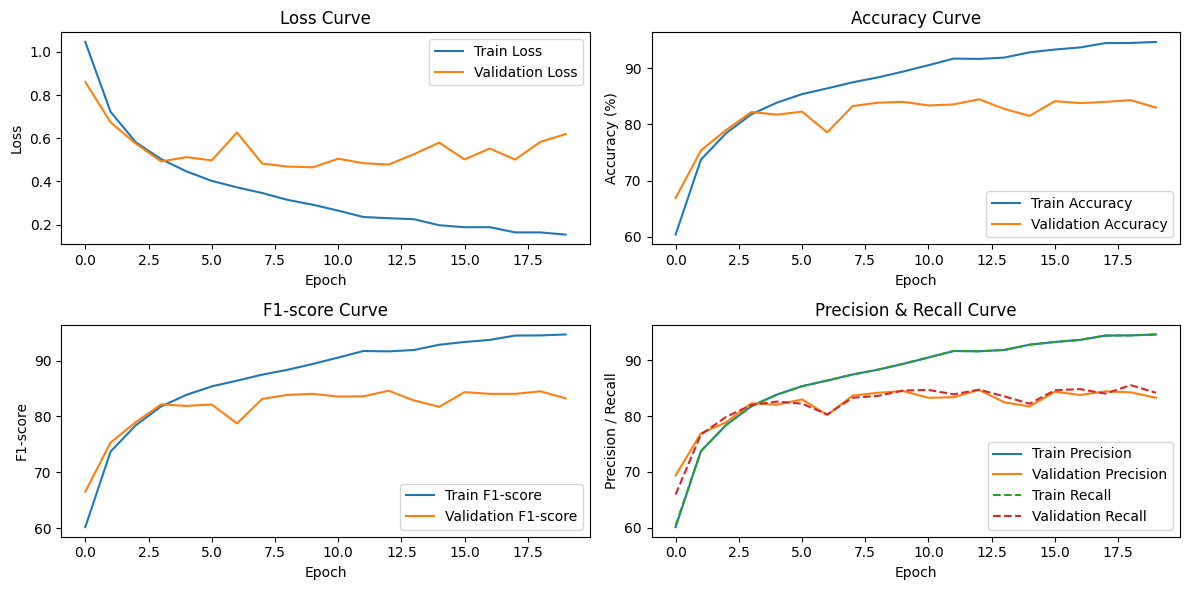

In [ ]:
plot_metrics(train_metrics, val_metrics).show()

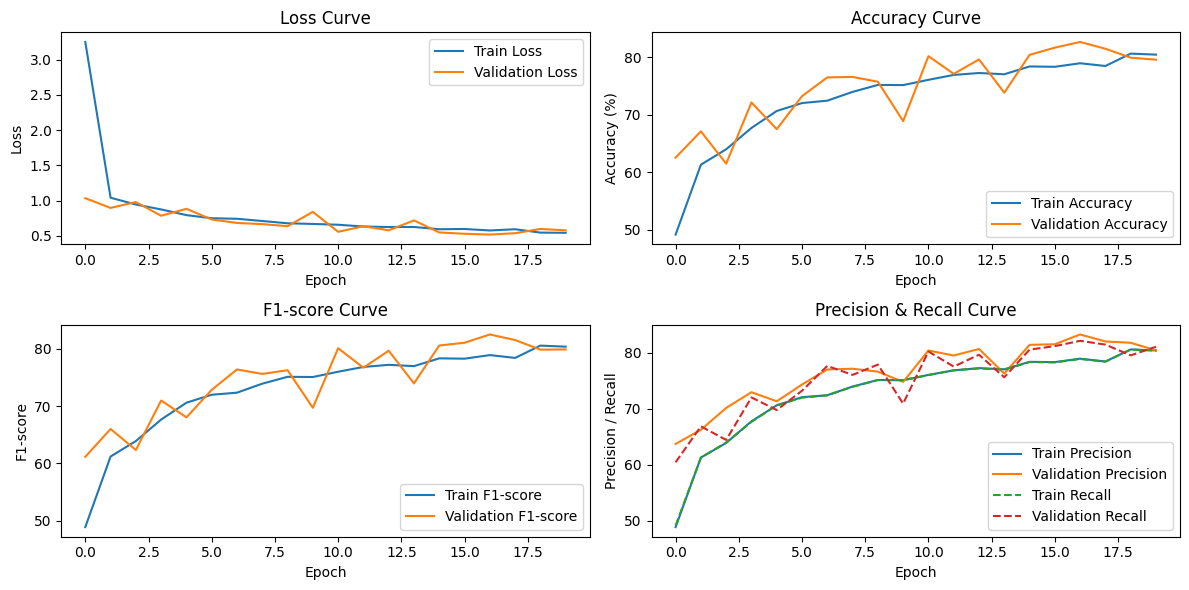

In [ ]:
plot_metrics(train_metrics, val_metrics).show()

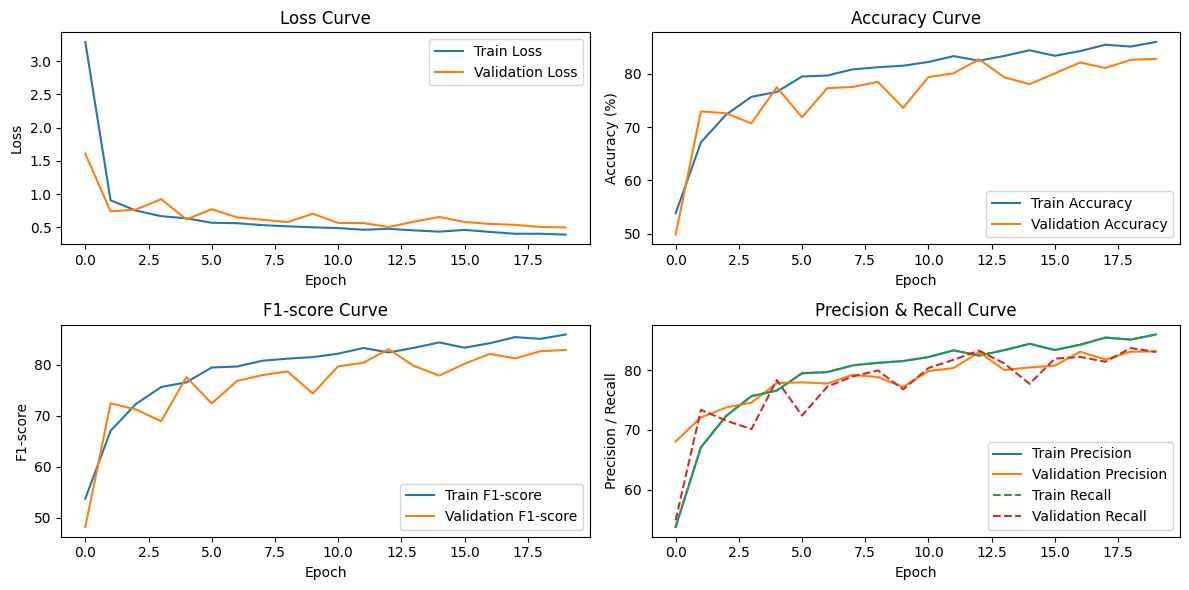

In [ ]:
plot_metrics(train_metrics, val_metrics).show()

In [ ]:
def evaluate_on_test(model, test_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("Confusion Matrix:")
    print(cm)

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': cm
    }

In [ ]:
test_metrics = evaluate_on_test(cnn_v0, test_dl, loss_function)

Test Loss: 0.5169
Accuracy: 0.8210
F1 Score: 0.8223
Precision: 0.8295
Recall: 0.8210
Confusion Matrix:


In [ ]:
test_metrics = evaluate_on_test(cnn_v0, test_dl, loss_function)

Test Loss: 0.4747
Accuracy: 0.8427
F1 Score: 0.8419
Precision: 0.8451
Recall: 0.8427
Confusion Matrix:
[[327   8   8  15   7  72]
 [  0 462   3   4   1   4]
 [  4   3 472  40  21  13]
 [  3   3  85 401  27   6]
 [ 15   2  39  19 415  20]
 [ 29  13   3   2   3 451]]


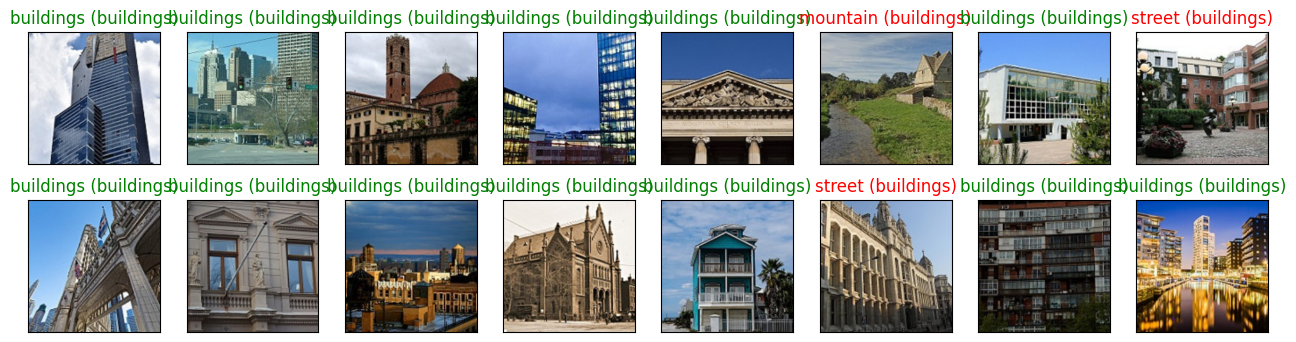

In [ ]:
data_iter = iter(test_dl)
images, labels = next(data_iter)
images = images.to(device)
labels = labels.to(device)

output = cnn_v0(images)
_, preds = torch.max(output, 1)

n = 16

fig = plt.figure(figsize=(n, 4))

for idx in np.arange(n):
    ax = fig.add_subplot(2, int(n/2), idx + 1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title(
        f"{str(classes[preds[idx].item()])} ({str(classes[labels[idx].item()])})",
        color=("green" if preds[idx] == labels[idx] else "red")
    )

plt.show()

In [ ]:
def class_accuracy(model, test_loader, device, class_names):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    accuracy_per_class = cm.diagonal() / cm.sum(axis=1)

    for i, acc in enumerate(accuracy_per_class):
        print(f"Accuracy for class '{class_names[i]}': {acc * 100:.2f}%")

    return accuracy_per_class

In [ ]:
accuracy_per_class = class_accuracy(cnn_v0, test_dl, device, data_train.classes)

Accuracy for class 'buildings': 87.41%
Accuracy for class 'forest': 89.87%
Accuracy for class 'glacier': 72.33%
Accuracy for class 'mountain': 76.95%
Accuracy for class 'sea': 85.49%
Accuracy for class 'street': 82.83%


In [ ]:
accuracy_per_class = class_accuracy(cnn_v0, test_dl, device, data_train.classes)

Accuracy for class 'buildings': 74.83%
Accuracy for class 'forest': 97.47%
Accuracy for class 'glacier': 85.35%
Accuracy for class 'mountain': 76.38%
Accuracy for class 'sea': 81.37%
Accuracy for class 'street': 90.02%


# Practice 3

## Manual optimization

In [ ]:
loss_functions = {
    "CE": nn.CrossEntropyLoss(),
    "NLLLoss": nn.NLLLoss()
}
learning_rates = [0.01, 0.001, 0.0001]
optimizers = {
    "Adam": lambda params, lr: torch.optim.Adam(params, lr=lr),
    "SGD": lambda params, lr: torch.optim.SGD(params, lr=lr, momentum=0.9),
    "AdamW": lambda params, lr: torch.optim.AdamW(params, lr=lr, weight_decay=1e-4)
}

In [ ]:
results = {}

for loss_name, loss_fn in loss_functions.items():
    for lr in learning_rates:
        for opt_name, opt_fn in optimizers.items():
            model = CNNModel(num_classes=6)
            optimizer = opt_fn(model.parameters(), lr)

            print(f"\nTraining with Loss: {loss_name}, Optimizer: {opt_name}, LR: {lr}")
            train_metrics, val_metrics = train(model, epochs=20, lr=lr, loss_function=loss_fn, optimizer=optimizer)

            model_filename = f"cnn_{loss_name}_{opt_name}_lr{lr}.pt"
            torch.save(model.state_dict(), model_filename)

            results[(loss_name, opt_name, lr)] = {
                "train": train_metrics,
                "val": val_metrics,
                "model_path": model_filename
            }


Training with Loss: CE, Optimizer: Adam, LR: 0.01
Epoch 1/20 - Loss: 13.8363, Accuracy: 28.04%, F1-score: 23.02, Precision: 29.79, Recall: 28.04 | Validation loss: 1.5425, Validation accuracy: 37.66%, F1-score: 24.86, Precision: 27.74, Recall: 33.30
Epoch 2/20 - Loss: 1.4580, Accuracy: 36.04%, F1-score: 28.05, Precision: 33.38, Recall: 36.04 | Validation loss: 1.3671, Validation accuracy: 45.06%, F1-score: 36.00, Precision: 37.74, Recall: 40.75
Epoch 3/20 - Loss: 1.3145, Accuracy: 42.46%, F1-score: 35.50, Precision: 40.09, Recall: 42.46 | Validation loss: 1.4195, Validation accuracy: 45.63%, F1-score: 36.42, Precision: 35.94, Recall: 42.19
Epoch 4/20 - Loss: 1.2338, Accuracy: 45.27%, F1-score: 40.84, Precision: 43.27, Recall: 45.27 | Validation loss: 1.1765, Validation accuracy: 50.11%, F1-score: 41.25, Precision: 44.03, Recall: 46.07
Epoch 5/20 - Loss: 1.2345, Accuracy: 45.05%, F1-score: 41.13, Precision: 44.24, Recall: 45.05 | Validation loss: 1.1596, Validation accuracy: 50.42%, F1

KeyboardInterrupt: 

Training with Loss: CE, Optimizer: Adam, LR: 0.01

First iterration was 20 min, than epoches trained quiker. Overall training - 55 min

Training with Loss: CE, Optimizer: SGD, LR: 0.01:
20 min



Manual optimization was running too long, and I lost access to the  GPU on Colab. But there are some conclusions on the results that I had time to run.

The best optimizer is SGD, and a learning rate of 0.01 is much worse than 0.001.

## Automated optimization

In [ ]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.4 MB/s eta 0:00:00


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))

        x = torch.flatten(x, start_dim=1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
import optuna
import torch.optim as optim

def objective(trial):
    lr = 0.001
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    dropout_rate = trial.suggest_categorical("dropout", [0.0, 0.2])

    model = CNNModel(dropout_rate=dropout_rate).to(device)

    loss_function = nn.CrossEntropyLoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    model.train()
    for epoch in range(1):
        for images, labels in train_dl:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()


    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in train_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    return f1

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("\n\Best params:")
print(study.best_params)

[I 2025-04-10 11:43:43,130] A new study created in memory with name: no-name-c87d5f13-814a-4821-b413-2248b74bc1a7
[I 2025-04-10 11:45:53,534] Trial 0 finished with value: 0.6962635990620628 and parameters: {'optimizer': 'SGD', 'dropout': 0.2}. Best is trial 0 with value: 0.6962635990620628.
[I 2025-04-10 11:48:03,143] Trial 1 finished with value: 0.7107904710636761 and parameters: {'optimizer': 'SGD', 'dropout': 0.2}. Best is trial 1 with value: 0.7107904710636761.
[I 2025-04-10 11:50:14,341] Trial 2 finished with value: 0.6191496966625586 and parameters: {'optimizer': 'Adam', 'dropout': 0.0}. Best is trial 1 with value: 0.7107904710636761.
[I 2025-04-10 11:52:27,892] Trial 3 finished with value: 0.7172191348024746 and parameters: {'optimizer': 'SGD', 'dropout': 0.2}. Best is trial 3 with value: 0.7172191348024746.
[I 2025-04-10 11:54:36,166] Trial 4 finished with value: 0.7458464610440741 and parameters: {'optimizer': 'SGD', 'dropout': 0.0}. Best is trial 4 with value: 0.7458464610440


\Best params:
{'optimizer': 'SGD', 'dropout': 0.0}


In [ ]:
cnn_v0 = CNNModel()
lr=0.001
loss_function = nn.CrossEntropyLoss()
epochs = 20
optimizer = optim.SGD(cnn_v0.parameters(), lr=lr, momentum=0.9)

In [ ]:
train_metrics, val_metrics = train(cnn_v0, epochs, lr, loss_function, optimizer)

Epoch 1/20 - Loss: 0.9637, Accuracy: 62.47%, F1-score: 62.40, Precision: 62.34, Recall: 62.47 | Validation loss: 0.7443, Validation accuracy: 72.25%, F1-score: 71.86, Precision: 71.89, Recall: 72.07
Epoch 2/20 - Loss: 0.7172, Accuracy: 72.82%, F1-score: 72.79, Precision: 72.77, Recall: 72.82 | Validation loss: 0.6590, Validation accuracy: 76.99%, F1-score: 76.32, Precision: 77.44, Recall: 76.27
Epoch 3/20 - Loss: 0.6373, Accuracy: 76.75%, F1-score: 76.74, Precision: 76.72, Recall: 76.75 | Validation loss: 0.6457, Validation accuracy: 75.78%, F1-score: 76.08, Precision: 77.13, Recall: 77.70
Epoch 4/20 - Loss: 0.5885, Accuracy: 78.48%, F1-score: 78.47, Precision: 78.46, Recall: 78.48 | Validation loss: 0.8452, Validation accuracy: 68.07%, F1-score: 67.77, Precision: 73.13, Recall: 70.11
Epoch 5/20 - Loss: 0.5448, Accuracy: 79.75%, F1-score: 79.73, Precision: 79.72, Recall: 79.75 | Validation loss: 0.5417, Validation accuracy: 80.64%, F1-score: 80.89, Precision: 80.75, Recall: 81.64
Epoch

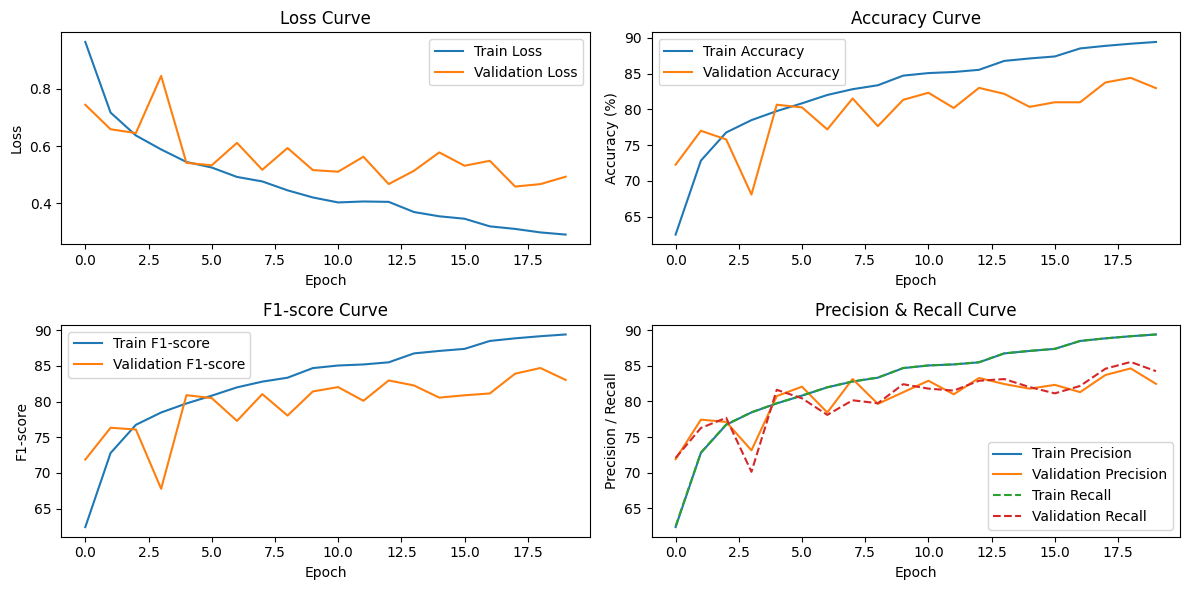

In [ ]:
plot_metrics(train_metrics, val_metrics).show()

In [ ]:
test_metrics = evaluate_on_test(cnn_v0, test_dl, loss_function)

Test Loss: 0.4810
Accuracy: 0.8457
F1 Score: 0.8445
Precision: 0.8474
Recall: 0.8457
Confusion Matrix:
[[382   8   2   1   6  38]
 [  5 460   1   3   1   4]
 [  6   8 404  73  47  15]
 [ 19   3  38 415  44   6]
 [ 18   9  13  10 450  10]
 [ 54   9   2   2   8 426]]


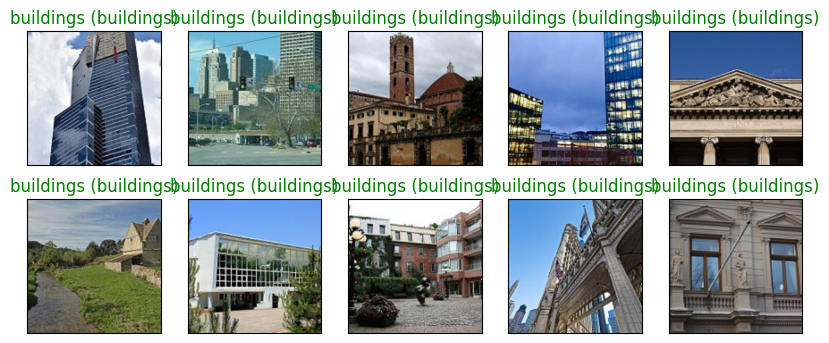

In [ ]:
data_iter = iter(test_dl)
images, labels = next(data_iter)
images = images.to(device)
labels = labels.to(device)

output = cnn_v0(images)
_, preds = torch.max(output, 1)

n = 10

fig = plt.figure(figsize=(n, 4))

for idx in np.arange(n):
    ax = fig.add_subplot(2, int(n/2), idx + 1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title(
        f"{str(classes[preds[idx].item()])} ({str(classes[labels[idx].item()])})",
        color=("green" if preds[idx] == labels[idx] else "red")
    )

plt.show()

In [ ]:
accuracy_per_class = class_accuracy(cnn_v0, test_dl, device, data_train.classes)

Accuracy for class 'buildings': 87.41%
Accuracy for class 'forest': 97.05%
Accuracy for class 'glacier': 73.06%
Accuracy for class 'mountain': 79.05%
Accuracy for class 'sea': 88.24%
Accuracy for class 'street': 85.03%


In [ ]:
import random

all_images = []
all_labels = []

for images, labels in test_dl:
    all_images.append(images)
    all_labels.append(labels)

all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)

class_images = {i: [] for i in range(6)}
for idx in range(len(all_images)):
    label = all_labels[idx].item()
    class_images[label].append((all_images[idx], label))

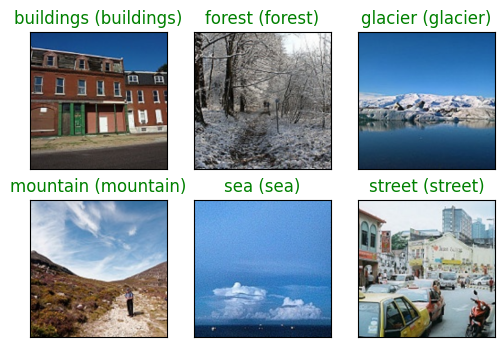

In [ ]:
n = 6
selected_images = []
selected_labels = []

for label, images in class_images.items():
    random.shuffle(images)
    selected_images.extend(images[:n//6])
    selected_labels.extend([label] * (n//6))


fig = plt.figure(figsize=(n, 4))

for idx in range(n):
    image, label = selected_images[idx]
    ax = fig.add_subplot(2, int(n / 2), idx + 1, xticks=[], yticks=[])
    imshow(image.cpu())
    ax.set_title(
        f"{str(classes[selected_labels[idx]])} ({str(classes[label])})",
        color=("green" if selected_labels[idx] == label else "red")
    )

plt.show()

In [ ]:
torch.save(cnn_v0.state_dict(), "cnn_finnal_v0.pth")

# Practice 4

In [ ]:
from torchvision import models
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 97.3MB/s]
